### Import

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

### Definisi Class

In [ ]:
class ImageEnhancer:
    def __init__(self):
        self.results = {}
    
    def load_image(self, image_path):
        img = Image.open(image_path).convert('RGB')
        return img
    
    def histogram_equalization(self, image):
        width, height = image.size
        channels = image.split()
        
        eq_channels = []
        for channel in channels:
            hist = [0] * 256
            for y in range(height):
                for x in range(width):
                    pixel_value = channel.getpixel((x, y))
                    hist[pixel_value] += 1
            
            # CDF
            cdf = [0] * 256
            cdf[0] = hist[0]
            for i in range(1, 256):
                cdf[i] = cdf[i-1] + hist[i]
            cdf_min = min(filter(lambda x: x > 0, cdf))
            cdf_range = cdf[-1] - cdf_min
            
            # Equalized channel
            equalized = Image.new('L', (width, height))
            for y in range(height):
                for x in range(width):
                    val = channel.getpixel((x, y))
                    new_val = int((cdf[val] - cdf_min) * 255 / cdf_range) if cdf_range > 0 else val
                    equalized.putpixel((x, y), new_val)
            eq_channels.append(equalized)
        
        eq_image = Image.merge('RGB', eq_channels)
        return eq_image
    
    def clahe_enhancement(self, image, clip_limit=2.0, tile_grid_size=(8, 8)):
        width, height = image.size
        tile_w, tile_h = tile_grid_size
        channels = image.split()
        
        enhanced_channels = []
        for channel in channels:
            enhanced = Image.new('L', (width, height))
            # Membagi tile dan equalize tiap tile
            for i in range(0, height, tile_h):
                for j in range(0, width, tile_w):
                    box = (j, i, min(j + tile_w, width), min(i + tile_h, height))
                    tile = channel.crop(box)
                    hist = [0] * 256
                    tw, th = tile.size
                    for y in range(th):
                        for x in range(tw):
                            val = tile.getpixel((x, y))
                            hist[val] += 1
                    
                    # Clip limit processing
                    max_clip = int(clip_limit * (tw * th) / 256)  # batas max per bin
                    excess = 0
                    for k in range(256):
                        if hist[k] > max_clip:
                            excess += hist[k] - max_clip
                            hist[k] = max_clip

                    # Redistribusi ke seluruh bins
                    increment = excess // 256 if excess > 0 else 0
                    remainder = excess % 256 if excess > 0 else 0
                    for k in range(256):
                        hist[k] += increment
                    # Tambahkan sisa overflow secara merata
                    for k in range(remainder):
                        hist[k] += 1
                    
                    # Hitung CDF dari histogram yang sudah di-clip
                    cdf = [0] * 256
                    cdf[0] = hist[0]
                    for k in range(1, 256):
                        cdf[k] = cdf[k-1] + hist[k]
                    cdf_min = min(filter(lambda x: x > 0, cdf))
                    cdf_range = cdf[-1] - cdf_min
                    
                    equalized_tile = Image.new('L', tile.size)
                    for y in range(th):
                        for x in range(tw):
                            val = tile.getpixel((x, y))
                            new_val = int((cdf[val] - cdf_min) * 255 / cdf_range) if cdf_range > 0 else val
                            equalized_tile.putpixel((x, y), new_val)
                    enhanced.paste(equalized_tile, box)
            enhanced_channels.append(enhanced)
        
        enhanced_image = Image.merge('RGB', enhanced_channels)
        return enhanced_image
    
    def calculate_metrics(self, original, enhanced, method_name):
        width, height = original.size
        orig_channels = original.split()
        enh_channels = enhanced.split()
        
        mse_channels = []
        
        for o_ch, e_ch in zip(orig_channels, enh_channels):
            orig_pixels = [o_ch.getpixel((x,y)) for y in range(height) for x in range(width)]
            enh_pixels = [e_ch.getpixel((x,y)) for y in range(height) for x in range(width)]
            
            mse = sum((orig_pixels[i] - enh_pixels[i])**2 for i in range(len(orig_pixels))) / len(orig_pixels)
            mse_channels.append(mse)
        
        mse_avg = sum(mse_channels) / 3
        psnr = 20 * np.log10 (255.0 / (mse_avg**0.5))
        
        return {
            'method': method_name,
            'mse': mse_avg,
            'psnr': psnr,
        }
    
    def plot_histogram(self, images, titles, filename=None):
        plt.figure(figsize=(15, 5))
        colors = ['red', 'green', 'blue']
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, len(images), i+1)
            width, height = img.size
            channels = img.split()
            for ch, color in zip(channels, colors):
                hist = [0]*256
                for y in range(height):
                    for x in range(width):
                        val = ch.getpixel((x,y))
                        hist[val] += 1
                plt.plot(hist, color=color, alpha=0.7)
            plt.title(f'Histogram - {title}')
            plt.xlabel('Intensity')
            plt.ylabel('Frequency')
            plt.grid(True, alpha=0.3)
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()
    
    def plot_comparison(self, images, titles, filename=None):
        plt.figure(figsize=(15, 5))
        for i, (img, title) in enumerate(zip(images, titles)):
            plt.subplot(1, len(images), i+1)
            plt.imshow(img)
            plt.title(title)
            plt.axis('off')
        plt.tight_layout()
        if filename:
            plt.savefig(filename, dpi=300, bbox_inches='tight')
        plt.show()

In [3]:
def print_metrics(metrics):
        print(f"\n=== Metrics for {metrics['method']} ===")
        print(f"{'Metric':<20} | {'Value':<15}")
        print("-" * 40)
        
        print(f"{'MSE (Average)':<20} | {metrics['mse']:<15.4f}")
        print(f"{'PSNR':<20} | {metrics['psnr']:<15.4f}")

### Proses Citra

In [4]:
# Inisialisasi objek ImageEnhancer
enhancer = ImageEnhancer()

### Jalankan Semua (Testing)


=== Metrics for Histogram Equalization ===
Metric               | Value          
----------------------------------------
MSE (Average)        | 15245.6013     
PSNR                 | 6.2994         

=== Metrics for CLAHE ===
Metric               | Value          
----------------------------------------
MSE (Average)        | 4355.4429      
PSNR                 | 11.7405        


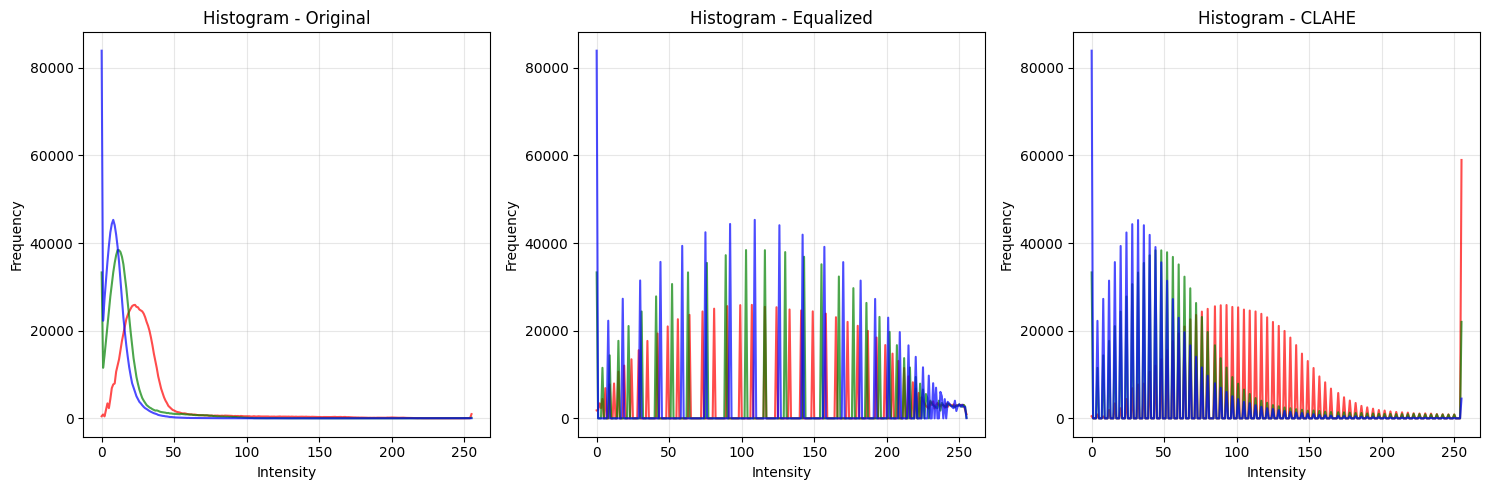

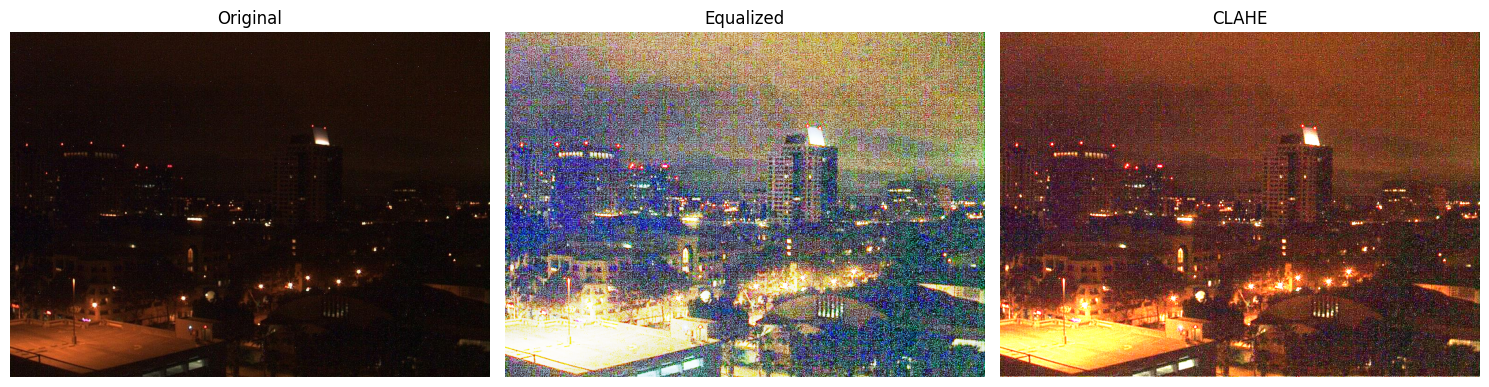

In [5]:
# Memuat gambar
image_path = 'citra1.jpg' 
original_image = enhancer.load_image(image_path)

# Melakukan histogram equalization
equalized_image = enhancer.histogram_equalization(original_image)

# Melakukan CLAHE enhancement
clahe_image = enhancer.clahe_enhancement(original_image)

# Menghitung metrik untuk gambar asli dan gambar yang telah diproses
metrics_equalized = enhancer.calculate_metrics(original_image, equalized_image, 'Histogram Equalization')
metrics_clahe = enhancer.calculate_metrics(original_image, clahe_image, 'CLAHE')

# Menampilkan metrik
print_metrics(metrics_equalized)
print_metrics(metrics_clahe)

# Menampilkan histogram
enhancer.plot_histogram([original_image, equalized_image, clahe_image], 
                         ['Original', 'Equalized', 'CLAHE'])

# Menampilkan perbandingan gambar
enhancer.plot_comparison([original_image, equalized_image, clahe_image], 
                          ['Original', 'Equalized', 'CLAHE'])



=== Metrics for Histogram Equalization ===
Metric               | Value          
----------------------------------------
MSE (Average)        | 17033.8205     
PSNR                 | 5.8177         

=== Metrics for CLAHE ===
Metric               | Value          
----------------------------------------
MSE (Average)        | 2584.7027      
PSNR                 | 14.0067        


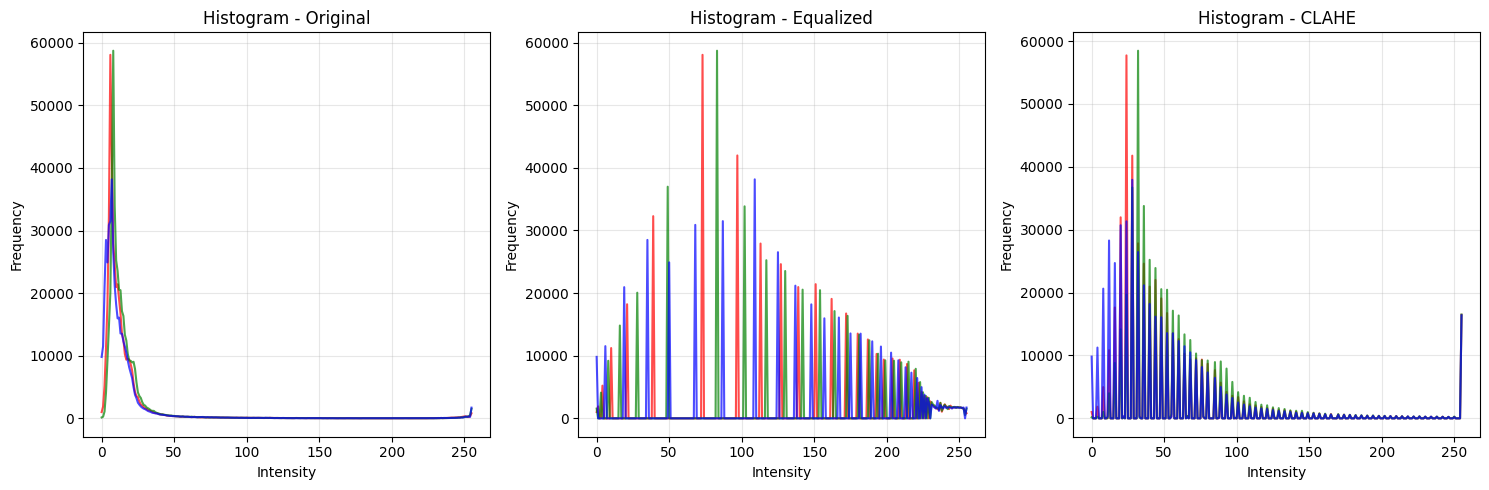

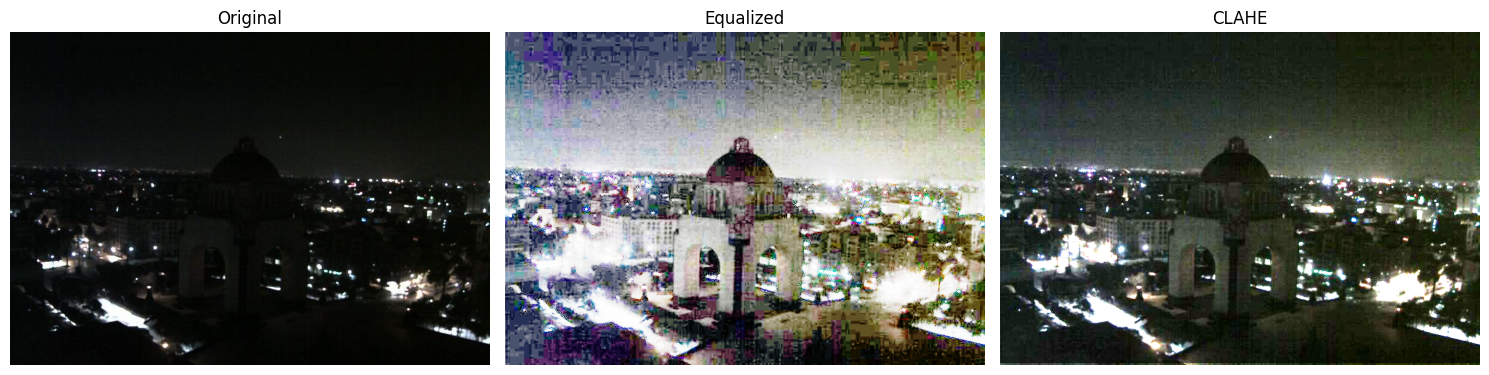

In [6]:
image_path = 'citra4.jpg' 
original_image = enhancer.load_image(image_path)

# Melakukan histogram equalization
equalized_image = enhancer.histogram_equalization(original_image)

# Melakukan CLAHE enhancement
clahe_image = enhancer.clahe_enhancement(original_image)

# Menghitung metrik untuk gambar asli dan gambar yang telah diproses
metrics_equalized = enhancer.calculate_metrics(original_image, equalized_image, 'Histogram Equalization')
metrics_clahe = enhancer.calculate_metrics(original_image, clahe_image, 'CLAHE')

# Menampilkan metrik
print_metrics(metrics_equalized)
print_metrics(metrics_clahe)

# Menampilkan histogram
enhancer.plot_histogram([original_image, equalized_image, clahe_image], 
                         ['Original', 'Equalized', 'CLAHE'])

# Menampilkan perbandingan gambar
enhancer.plot_comparison([original_image, equalized_image, clahe_image], 
                          ['Original', 'Equalized', 'CLAHE'])


=== Metrics for Histogram Equalization ===
Metric               | Value          
----------------------------------------
MSE (Average)        | 11893.6759     
PSNR                 | 7.3776         

=== Metrics for CLAHE ===
Metric               | Value          
----------------------------------------
MSE (Average)        | 6367.2184      
PSNR                 | 10.0913        


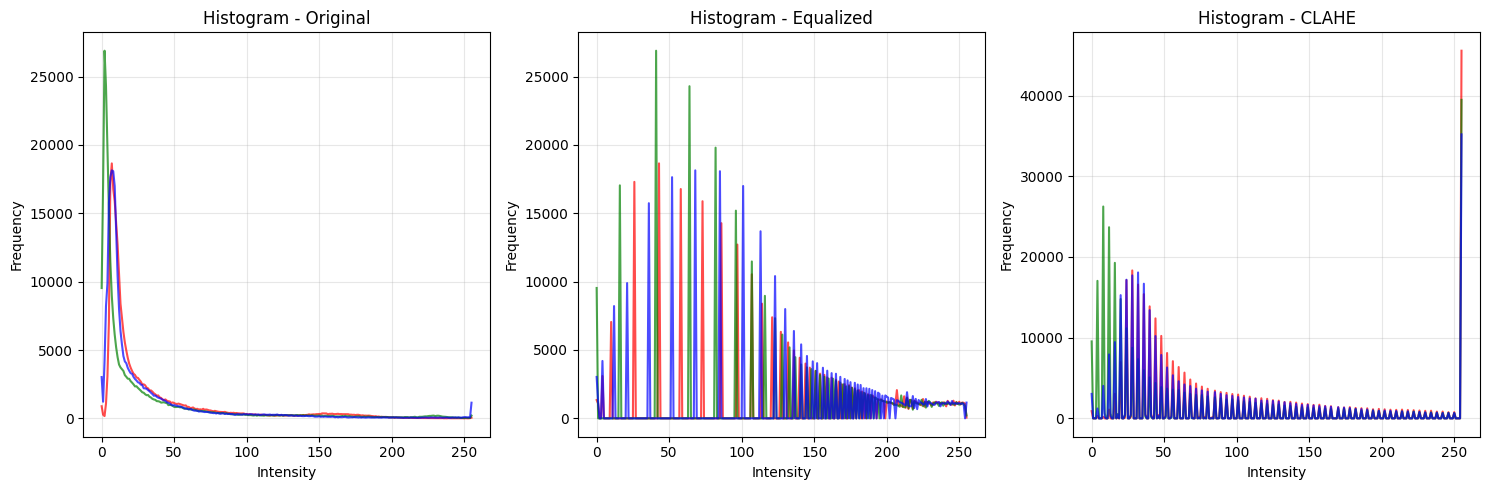

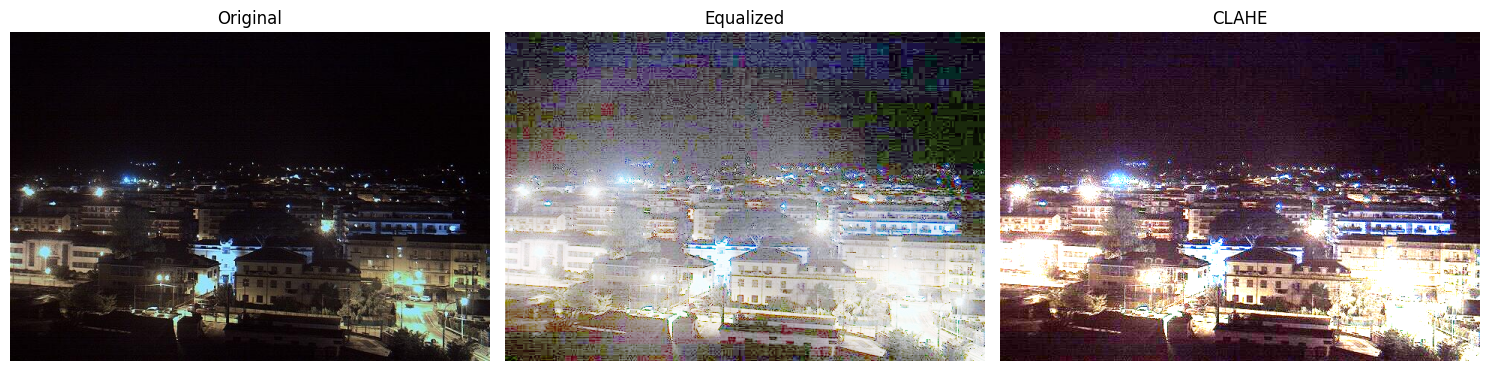

In [7]:
image_path = 'citra5.jpg' 
original_image = enhancer.load_image(image_path)

# Melakukan histogram equalization
equalized_image = enhancer.histogram_equalization(original_image)

# Melakukan CLAHE enhancement
clahe_image = enhancer.clahe_enhancement(original_image)

# Menghitung metrik untuk gambar asli dan gambar yang telah diproses
metrics_equalized = enhancer.calculate_metrics(original_image, equalized_image, 'Histogram Equalization')
metrics_clahe = enhancer.calculate_metrics(original_image, clahe_image, 'CLAHE')

# Menampilkan metrik
print_metrics(metrics_equalized)
print_metrics(metrics_clahe)

# Menampilkan histogram
enhancer.plot_histogram([original_image, equalized_image, clahe_image], 
                         ['Original', 'Equalized', 'CLAHE'])

# Menampilkan perbandingan gambar
enhancer.plot_comparison([original_image, equalized_image, clahe_image], 
                          ['Original', 'Equalized', 'CLAHE'])